# Drug-Drug side effects prediction

In this notebook, we will face the problem of predicting the side effects of drugs from a Tensor Factorization perspective. Goal of this report is to examine the use of Tensor Networks in biomedical data.
 

## Datasets

As our dataset we use a multirelational network of drug-drug interactions, where each interaction represents a side effect type. In total we have 645 drugs and 1317 different side effects. The dataset used can be found in snap.stanford.edu/decagon . 

## Load dataset and statistics

Here we present some basic statistics derived from the dataset. 

Imports:

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import scipy.sparse as sp
#import t3f
#import tensorflow as tf
import seaborn as sns



from numpy import dot, array, zeros, setdiff1d
from numpy.random import shuffle
from scipy.sparse import lil_matrix, csr_matrix
from sktensor import dtensor, cp_als, tucker, rescal, ktensor
from sklearn.metrics import precision_recall_curve, auc, average_precision_score, precision_recall_fscore_support
#from tensorly import tensor #, tucker_to_tensor, kruskal_to_tensor

Now let's load the data and convert the .csv files to adjacency matrices and then to tensors (we only use drug-drug networks).

In [2]:
def load_csvfile(filename):
    return pd.read_csv(filename)

def convert_data_to_adjMatrix(data):
    # TODO:: refactor how to get columns
    columns = (data.iloc[:, i] for i in range(2))
    df = pd.crosstab(*columns)
    #df = pd.crosstab(data.a, data.b)
    idx = df.columns.union(df.index)
    adj_matrix = df.reindex(index=idx, columns=idx, fill_value=0)
    return idx, adj_matrix.values

def convert_dataframe_to_sparse(matrix):
    return sp.csr_matrix(matrix)

data_directory = "./data/"
filenames = [#"bio-decagon-ppi.csv",
             #    "bio-decagon-targets.csv",
             #    "bio-decagon-targets-all.csv",
                 "bio-decagon-combo.csv",
             #    "merged_data.csv"
]
datasets = {}
for f in filenames:
    datafile = load_csvfile(data_directory+f)
    names_of_rows, adj_matrix = convert_data_to_adjMatrix(datafile)
    sparse_matrix = convert_dataframe_to_sparse(adj_matrix)
    datasets[f] = sparse_matrix          


So, we have loaded our datasets in memory. Let's calculate some statistics for each network. We count the number of relations and the sparsity.


In [3]:
def plot_counts(dist, title="", x_label="", y_label=""):
    plt.figure(figsize=(6, 3.5))
    plt.plot(dist)
    plt.xlabel(x_label)
    plt.title("Counts of interactions")
    plt.tight_layout()
    plt.ylabel(y_label)
    plt.show()

def plot_distribution(dist, title="", x_label="", y_label=""):
    print("Median:", np.median(dist))
    plt.figure(figsize=(6, 3.5))
    sns.set_context("paper", font_scale=1.8)
    sns.set_style('ticks')
    sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})
    sns.distplot(dist, kde=False, color=sns.xkcd_rgb['blue'], bins=30, hist_kws={"alpha" : 0.7})
    plt.xlabel(x_label)
    plt.title("Distribution")
    plt.tight_layout()
    plt.gcf().subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)
    plt.ylabel(y_label)
    plt.show()

def plot_sparsity(dist):
    print(dist.shape)
    plt.figure()
    plt.title("Sparsity")
    plt.spy(dist, precision=0.5, markersize=5)
    plt.tight_layout()
    plt.show()

def get_matrix_stats(matrix):
    # count nonzero values
    nnz_count = len(matrix.data)
    print("Nonzero values: ", nnz_count)
    # sparsity of matrix
    sparsity = 1 - nnz_count / float(matrix.shape[0]**2)
    print("Sparsity: ", sparsity)
    # count max interactions
    count_nnz_matrix = matrix.getnnz(axis=1)
    print(count_nnz_matrix.shape)
    #print type(count_nnz_matrix)
    #print count_nnz_matrix
    #print count_nnz_matrix.max(axis=0)
    row_max = [i
                  for i in range(count_nnz_matrix.shape[0])
                  if count_nnz_matrix[i] == count_nnz_matrix.max(axis=0)]
    print("Row with maximum counts: ",  row_max)

    # find topN interactions with indices
    N = 3
    topN_indices = np.argpartition(count_nnz_matrix, -N)[-N:]
    #print topN_indices
    # values of topN items
    #print count_nnz_matrix[topN_indices]

    #
    plot_sparsity(matrix)
    plot_counts(count_nnz_matrix,
                      "",
                      "node",
                      "Number of interactions")
    plot_distribution(count_nnz_matrix,
                      "",
                      "Number of nodes",
                      "Number of interactions")




### The plots for the "bio-decagon-ppi.csv" are:


In [ ]:
get_matrix_stats(datasets["bio-decagon-ppi.csv"])

### The plots for the "bio-decagon-targets.csv" are:


In [ ]:
get_matrix_stats(datasets["bio-decagon-targets.csv"])

### The plots for the "bio-decagon-targets-all.csv" are:


In [ ]:
get_matrix_stats(datasets["bio-decagon-targets-all.csv"])

### The plots for the "bio-decagon-combo.csv" are:


('Nonzero values: ', 63473)
('Sparsity: ', 0.8474298419566132)
(645,)
('Row with maximum counts: ', [20])
(645, 645)


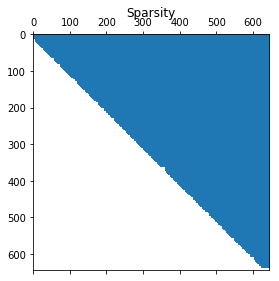

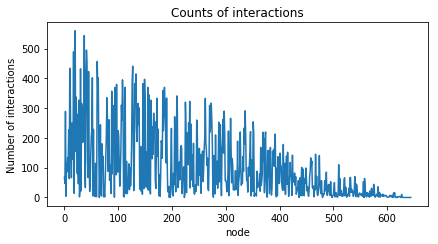

('Median:', 55.0)


/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


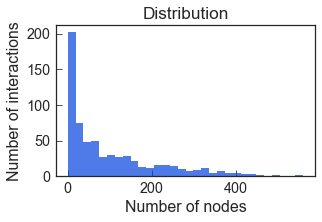

In [4]:
get_matrix_stats(datasets["bio-decagon-combo.csv"])

In [ ]:
dd = load_csvfile("./data/bio-decagon-combo.csv")
all_ = set(dd['STITCH 1'].values.tolist() +dd['STITCH 2'].values.tolist())

In [7]:
def load_csvfile(filename):
    return pd.read_csv(filename)

def convert_data_to_adjMatrix(data):
    # TODO:: refactor how to get columns
    columns = (data.iloc[:, i] for i in range(2))
    df = pd.crosstab(*columns)
    #df = pd.crosstab(data.a, data.b)
    idx = df.columns.union(df.index)
    adj_matrix = df.reindex(index=idx, columns=idx, fill_value=0)
    return idx, adj_matrix.values

def convert_dataframe_to_sparse(matrix):
    return sp.csr_matrix(matrix)

datafile = load_csvfile('./data/'+'bio-decagon-ppi.csv')
grouped = datafile.groupby('Gene 1')['Gene 2'].apply(list)
all_ = set(datafile['Gene 1'].values.tolist()+datafile['Gene 2'].tolist())
pp = []
cc = 0
protein_protein = np.zeros((len(gene2id.keys()), len(gene2id.keys())))
for gene, row in gene2id.iteritems():
    try:
        cur = [c_ for c_ in grouped[gene] if c_ in gene2id]
        cur = map(gene2id.get, cur)
        protein_protein[row, cur] = 1
    except KeyError:
        cc +=1
        continue
print cc
protein_protein = scipy.sparse.csr_matrix(protein_protein)

114


In [8]:
drug_protein_drug = np.dot(drug_sparse, protein_protein)
drug_protein_drug.shape

(645, 3648)

In [5]:
dd2 = load_csvfile("./data/bio-decagon-targets-all.csv")
dd2 = dd2.groupby('STITCH')['Gene'].apply(list)
c = 0
max_ = 0
drug_feats = []
wanted_rows = []
gene2id = {}
ii = 0
for item in dd2.index:
    try:
        wanted_rows.append(names_of_rows.get_loc(item))
        cur = dd2.loc[item]
        for c_ in cur:
           if not(c_ in gene2id):
                gene2id[c_] = ii
                ii +=1
        drug_feats.append(cur)
    except KeyError:
        pass
#     if item in names_of_rows:
#         c += 1
#         #print item
        
#     else:
#         drug_feats.append([])
import scipy
# = []
print len(drug_feats)
drug_feats2 = np.zeros((len(names_of_rows), len(gene2id.keys())))
for i, cur in enumerate(drug_feats):
    ind = map(gene2id.get, cur)
    row = wanted_rows[i]
    drug_feats2[row,ind] = 1
print drug_feats2.shape
drug_sparse = scipy.sparse.csr_matrix(drug_feats2)
del dd2, drug_feats, drug_feats2
#     tmp = scipy.sparse.csr_matrix((max_,1))
#     tmp[cur] = 1
#     drug_feats2.append(tmp)
    

284
(645, 3648)


In [6]:
with open)

(645, 3648)


In [ ]:
datafile = load_csvfile(data_directory+'bio-decagon-ppi.csv')
names_of_rows, pp_adj = convert_data_to_adjMatrix(datafile)

In [ ]:
adj_matrix.shape

As the input data is a matrix, this result does not reflect all relationships in the network. We only assume one interaction between drugs for all relationships.

To include all relationships we have to build a tensor for drug-drug relations.

In [6]:
def convert_data_to_multiarray(data):
    """
    Convert data to a multiway array by stacking matrix slices
    (also sparse version)
    """
    adj_matrices = []
    adj_sp_matrices = []
    unique_seffects = data.iloc[:, 2].unique()
    # build a huge zeros matrix for all nodes
    columns = (data.iloc[:, i] for i in range(2))
    df = pd.crosstab(*columns)
    #df = pd.crosstab(data.a, data.b)
    idx = df.columns.union(df.index)
    adj_matrix_all = df.reindex(index=idx, columns=idx, fill_value=0)

    # for each disease get all interaction rows
    # and construct a DxDx#unique_seffects
    #print len(unique_seffects.tolist())

    for se in unique_seffects.tolist():
        adj_matrix_all[adj_matrix_all>0] = 0
        subdata = data.loc[data.iloc[:, 2] == se]
        #columns = (subdata.iloc[:, i] for i in range(3))
        for c in subdata.values:
            row = c[0]
            column = c[1]
            adj_matrix_all.at[row, column] = 1
        adj_matrices.append(adj_matrix_all.values)
        sparse_matrix = convert_dataframe_to_sparse(adj_matrix_all)
        adj_sp_matrices.append(sparse_matrix)
    #multiarray = np.dstack(adj_matrices)

    return adj_sp_matrices

In [7]:
datafile = load_csvfile(data_directory+"bio-decagon-combo.csv")
multiarray = convert_data_to_multiarray(datafile)

In [ ]:
multiarray[1].shape

## Prediction with Tensor Factorization

We will consider the side effect prediction problem as a link prediction. For this reason we employ tensor factorization approaches to tackle it.

### Methods used

We use:

* Rescal
* Canonical
* Tucker
* Tensor-Train

We also plan to test supevised tensor decomposition techniques. 


In [ ]:
RANK = 5

def predict_rescal_als(T, isClass=False):
    A, R, _, _, _ = rescal.als(
        T, 100, init='nvecs', conv=1e-3,
        lambda_A=10, lambda_R=10
    )
    n = A.shape[0]
    if isClass:
        return A
    P = zeros((n, n, len(R)))
    for k in range(len(R)):
        P[:, :, k] = dot(A, dot(R[k], A.T))
    return P

def parafac(data):
    T = dtensor(data)
    P = cp_als(T, RANK, init="random")
    U = [tensor(m) for m in P[0].U]
    return kruskal_to_tensor(U)

def tucker_(data):
    T = dtensor(data)
    core, U = tucker.hooi(T, RANK)
    return tucker_to_tensor(core, U)

def tensor_train(data):
    with tf.Session() as sess:
        t = tf.convert_to_tensor(data, dtype=tf.float32)
        data_tt = t3f.to_tt_tensor(t, max_tt_rank=32)
        #data_tt_round = t3f.round(data_tt, max_tt_rank=2)
        P = t3f.full(data_tt)
        P = sess.run(P)
        return P

In [59]:
def normalize_predictions(P, e, k):
    print(P.shape)
    for a in range(e):
        for b in range(e):
            nrm = np.linalg.norm(P[a, b, :k])
            if nrm != 0:
                # round values for faster computation of AUC-PR
                P[a, b, :k] = np.round_(P[a, b, :k] / nrm, decimals=3)
    return P

In [ ]:
def innerfold(T, mask_idx, target_idx, e, k, sz, GROUND_TRUTH):
    auc_methods = {}
    Tc = [Ti.copy() for Ti in T]
    mask_idx = np.unravel_index(mask_idx, (e, e, k))
    target_idx = np.unravel_index(target_idx, (e, e, k))

    # set values to be predicted to zero
    for i in range(len(mask_idx[0])):
        #print(Tc[mask_idx[2][i]][mask_idx[0][i], mask_idx[1][i]])
        Tc[mask_idx[2][i]][mask_idx[0][i], mask_idx[1][i]] = 0

    #print(len(mask_idx[0]))
    #print(len(target_idx[0]))
    GT = GROUND_TRUTH[target_idx]
    print(len(GT))
    # predict unknown values
    # RESCAL
    print("RESCAL decomposition...")
    P = predict_rescal_als(Tc)
    P = normalize_predictions(P, e, k)
    print(len(P[target_idx]))
    print("Error: ", np.linalg.norm(GROUND_TRUTH-P))
    prec, recall, _ = precision_recall_curve(GROUND_TRUTH[target_idx], P[target_idx])
    #prec, recall, _, _ = precision_recall_fscore_support(GROUND_TRUTH[target_idx], P[target_idx])
    #print(prec.shape)
    avg_prec = average_precision_score(GROUND_TRUTH[target_idx], P[target_idx])
    print("avg_p: ",avg_prec)
    auc_methods['rescal'] = {'auc': auc(recall, prec),
                             'prec': avg_prec,}
                             #'recall': recall}
    Tc_np = [t.toarray() for t in Tc]
    Tc_np = np.array(Tc_np).T
    """
    # tucker
    print("Tucker decomposition...")
    P = tucker_(Tc_np)
    P = normalize_predictions(P, e, k)
    print("Error: ", np.linalg.norm(GROUND_TRUTH-P))
    prec, recall, _ = precision_recall_curve(GROUND_TRUTH[target_idx], P[target_idx])
    #prec, recall, _, _ = precision_recall_fscore_support(GROUND_TRUTH[target_idx], P[target_idx])
    avg_prec = average_precision_score(GROUND_TRUTH[target_idx], P[target_idx])
    print("avg_p: ",avg_prec)
    auc_methods['tucker'] = {'auc': auc(recall, prec),
                             'prec': avg_prec,}
                             #'recall': recall}
    # cp
    print("Parafac decomposition...")
    P = parafac(Tc_np)
    P = normalize_predictions(P, e, k)
    print("Error: ", np.linalg.norm(GROUND_TRUTH-P))
    prec, recall, _ = precision_recall_curve(GROUND_TRUTH[target_idx], P[target_idx])
    #prec, recall, _, _ = precision_recall_fscore_support(GROUND_TRUTH[target_idx], P[target_idx])
    avg_prec = average_precision_score(GROUND_TRUTH[target_idx], P[target_idx])
    print("avg_p: ",avg_prec)
    auc_methods['parafac'] = {'auc': auc(recall, prec),
                              'prec': avg_prec,}
                              #'recall': recall}
    
    # tensor train
    print("Tensor Train decomposition...")
    P = tensor_train(Tc_np)
    P = normalize_predictions(P, e, k)
    print("Error: ", np.linalg.norm(GROUND_TRUTH-P))
    prec, recall, _ = precision_recall_curve(GROUND_TRUTH[target_idx], P[target_idx])
    #prec, recall, _, _ = precision_recall_fscore_support(GROUND_TRUTH[target_idx], P[target_idx])
    avg_prec = average_precision_score(GROUND_TRUTH[target_idx], P[target_idx])
    print("avg_p: ",avg_prec)
    auc_methods['tt'] = {'auc': auc(recall, prec),
                         'prec': avg_prec,}
                         #'recall': recall}
    """

    return auc_methods

In [ ]:
def calculate_averages(results_dict):
    methods = results_dict[0].keys()
    averages = {}
    for method in methods:
        avprec = []
        avrec = []
        for f in results_dict.keys():
            avprec.append(results_dict[f][method]['prec'])
            #avrec.append(results_dict[f][method]['recall'])
            #avprec.append(results_dict[f][method]['prec'])
            #avrec.append(results_dict[f][method]['recall'])
        averages[method] = {'avprec': avprec,}
                            #'avrec': avrec}
    return averages

In [ ]:
def plot_pr_curve(recall, precision, m):
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve for '+str(m))
    plt.show()

In [ ]:
def plot_all(results):
    from itertools import cycle
    lines = ["-","--","-.",":"]
    linecycler = cycle(lines)
    plt.figure()
    for r in results.items():
        x = list(range(len(r[1]['avprec'])))
        #print(x)
        y = r[1]['avprec']
        plt.plot(x, y,next(linecycler),label=str(r[0]))
    plt.ylabel('Precision')
    plt.xticks(x)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

In [68]:
def to_tensor(multiarray_sparse, sample=None):
    marrays = []
    if sample:
        sorted_m = sorted(multiarray_sparse, key=csr_matrix.getnnz)
        for m in sorted_m[-sample:]:
            marrays.append(m.toarray())
        T = np.array(marrays).T
    else:
        for m in multiarray_sparse:
            marrays.append(m.toarray())
        T = np.array(marrays).T
    return T

In [67]:
data = to_tensor(multiarray, sample=500)
e, k = data.shape[0], data.shape[2]
print("Dataset size: ", data.shape)
SZ = e * e * k
# T for rescal
T = [lil_matrix(data[:, :, i]) for i in range(k)]

[<645x645 sparse matrix of type '<type 'numpy.int64'>'
	with 1 stored elements in Compressed Sparse Row format>, <645x645 sparse matrix of type '<type 'numpy.int64'>'
	with 2 stored elements in Compressed Sparse Row format>, <645x645 sparse matrix of type '<type 'numpy.int64'>'
	with 2 stored elements in Compressed Sparse Row format>, <645x645 sparse matrix of type '<type 'numpy.int64'>'
	with 2 stored elements in Compressed Sparse Row format>, <645x645 sparse matrix of type '<type 'numpy.int64'>'
	with 2 stored elements in Compressed Sparse Row format>, <645x645 sparse matrix of type '<type 'numpy.int64'>'
	with 2 stored elements in Compressed Sparse Row format>, <645x645 sparse matrix of type '<type 'numpy.int64'>'
	with 3 stored elements in Compressed Sparse Row format>, <645x645 sparse matrix of type '<type 'numpy.int64'>'
	with 3 stored elements in Compressed Sparse Row format>, <645x645 sparse matrix of type '<type 'numpy.int64'>'
	with 3 stored elements in Compressed Sparse Row 

('Dataset size: ', (645, 645, 500))


KeyboardInterrupt: 

In [55]:
print e, k
print data.shape

645 500
(645, 645, 500)


1317

In [56]:
print("RESCAL decomposition...")

RANK = 10

def predict_rescal_als(T, RANK=10, attributes=None, isClass=False):
    if attributes:
        A, R, _, _, _ = rescal.als(
            T, RANK, init='nvecs', conv=1e-3,
            lambda_A=10, lambda_R=10, attr=attributes
        )
    else:
        A, R, _, _, _ = rescal.als(
            T, RANK, init='nvecs', conv=1e-3,
            lambda_A=10, lambda_R=10
        )
    n = A.shape[0]
    if isClass:
        return A, R
    P = zeros((n, n, len(R)))
    for k in range(len(R)):
        P[:, :, k] = dot(A, dot(R[k], A.T))
    return P

A, R = predict_rescal_als(T, RANK=RANK, attributes=[drug_sparse], isClass=True)
print A.shape
print len(R), R[0].shape

RESCAL decomposition...
(645, 10)
500 (10, 10)


In [75]:
for lab, attr in zip(['PROTEIN IN X'], 
                     [[drug_sparse]]):
    print lab
    if lab == 'PROTEIN IN X':
        data = to_tensor(multiarray+[np.dot(drug_protein_drug, drug_sparse.T)], sample=500)
    else:
        data = to_tensor(multiarray, sample=500)
    e, k = data.shape[0], data.shape[2]
    print("Dataset size: ", data.shape)
    SZ = e * e * k
    # T for rescal
    T = [lil_matrix(data[:, :, i]) for i in range(k)]
    A, R = predict_rescal_als(T, RANK=RANK, attributes=attr, isClass=True)
    n = A.shape[0]
    P = zeros((n, n, len(R)))
    for k_i in range(len(R)):
        P[:, :, k_i] = dot(A, dot(R[k_i], A.T))
    P = normalize_predictions(P, e, k)
    print("Error: ", np.linalg.norm(data-P))

PROTEIN IN X
('Dataset size: ', (645, 645, 500))
(645, 645, 500)
('Error: ', 240139.81892005258)


In [ ]:
n = A.shape[0]
P = zeros((n, n, len(R)))
for k_i in range(len(R)):
    P[:, :, k_i] = dot(A, dot(R[k_i], A.T))
P = normalize_predictions(P, e, k)
print("Error: ", np.linalg.norm(data-P))

In [ ]:
#print A.shape
#print R[0].shape
#print P[:,:,0]
#print data[:,:,0]
n = A.shape[0]
P = zeros((n, n, len(R)))
for k_i in range(len(R)):
    P[:, :, k_i] = dot(A, dot(R[k_i], A.T))
P = normalize_predictions(P, e, k)
print("Error: ", np.linalg.norm(data-P))

### Results for k-folds

In [ ]:
AUC_test = {}
FOLDS = 1
for f in range(FOLDS):
    # test sets
    # prepare indices for test values
    ones_indices = np.nonzero(data)
    zeros_indices = np.where(data == 0)
    ones_ravel = np.ravel_multi_index(ones_indices, (e,e,k))
    zeros_ravel = np.ravel_multi_index(zeros_indices, (e,e,k))
    shuffle(ones_ravel)
    shuffle(zeros_ravel)
    random_ones_indices = ones_ravel[:int((np.count_nonzero(data)/50))]
    random_zeros_indices = zeros_ravel[:int((np.count_nonzero(data)/50))]
    test_indices = np.append(random_ones_indices, random_zeros_indices)
    #print(test_indices.shape)
    print('Test Fold %d' % f)
    AUC_test[f] = innerfold(T, test_indices, test_indices, e, k, SZ, data)
averages_methods = calculate_averages(AUC_test)
#for m in averages_methods.items():
#    plot_pr_curve(m[1]['avrec'], m[1]['avprec'], m[0])

plot_all(averages_methods)

### Building a classifier with pairs of drugs learned from latent factors

As we want to classify pairs of drugs, we can build a classifier using latent factors learned in the previous stages. To clarify, as training instances we use the concatenation(or addition) of two rows of the A latent matrix produced from RESCAL (each row is the latent representation of a drug). 

In [ ]:
def split_dataset(dataset, train_size=10000, test_size=2000):
    test_indices = []
    train_indices = []
    all_ones = []
    zeros_ind = []
    n = dataset[0].shape[0]
    all_possible_pairs = []
    for i in range(n):
        for j in range(n):
            all_possible_pairs.append((i,j))
    #print((all_possible_pairs[:100]))
    for adj_m in dataset:
        nz = adj_m.nonzero()
        nz_i = nz[0]
        nz_j = nz[1]
        indices = [(v, nz_j[i]) for i, v in enumerate(nz_i)]
        #print(len(indices))
        all_ones += indices
        #print(all_ones)
    #print(len(all_ones))
    uniq_ones = list(set(all_ones))
    zeros_ind = list(set(all_possible_pairs) - set(all_ones))
    shuffle(all_ones)
    shuffle(zeros_ind)
    train_indices = all_ones[:train_size] + zeros_ind[:train_size]
    test_indices = all_ones[train_size:train_size+test_size] + zeros_ind[train_size:train_size+test_size]
    #print(len(train_indices))
    #print(len(test_indices))
    return train_indices, test_indices

        
        
    

In [ ]:
from sklearn import svm 

avg_ac = []
for f in range(FOLDS):
    # test sets
    # prepare indices for train and test
    train_indices, test_indices = split_dataset(multiarray,
                                                train_size=10000,
                                                test_size=2000)
    
    Tc = [Ti.copy() for Ti in T]
    A = predict_rescal_als(Tc, isClass=True)
    print('Fold %d' % f)
    # prepare input for svm
    X = []
    y = []
    half = int(len(train_indices)/2)
    print(half)
    for pair in train_indices[:half]:
        X.append(np.append(A[pair[0]],A[pair[1]]))
        y.append(1)
    for pair in train_indices[half:]:
        X.append(np.append(A[pair[0]],A[pair[1]]))
        y.append(0)
                 
    clf = svm.SVC()
    clf.fit(X, y)
                 
    #prepare indices for prediction
    testX = []
    testY = []
    half = int(len(test_indices)/2)
    for pair in test_indices[:half]:
        testX.append(np.append(A[pair[0]],A[pair[1]]))
        testY.append(1)
    for pair in test_indices[half:]:
        testX.append(np.append(A[pair[0]],A[pair[1]]))
        testY.append(0)
    predictions = clf.predict(testX)
                     
    from sklearn.metrics import precision_recall_curve, accuracy_score
    import matplotlib.pyplot as plt
    precision, recall, _ = precision_recall_curve(testY, predictions)
    acs = accuracy_score(testY, predictions)
    avg_ac.append(acs)
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()

print("Average Accuracy after folds: ", sum(avg_ac)/FOLDS) 



### Comparing with link prediction

In order to compare with prediction of missing links we redesign the evaluation of classification task. Here we plan to exclude the pairs of drugs that will be used  as testing instances   from the factorization process.

### Classification of multiple classes - side effects

Here we examine the case of classifying the type of side effects between two drugs.

### Integrate all networks with node embeddings

At the moment we have examined only the drug-drug side effects network (645x645). However, there are two more networks available i) the protein-protein interaction network (19081x19081) and ii) the drug-protein interaction network (9569x9569). How to combine all this information together?

1. we can concatenate all networks together, resulting in a huge tensor of size (645+19081+9569)x(645+19081+9569)x(2000+). Following this idea, we will come up with a very sparse tensor, for most of the relations in the 3rd dimension. (will probably lead to memory and computational time issues)
2. we can use the p-p and d-p networks to compute a node embedding for each drug. This embedding will be used then as input to the factorizatio of d-d network. Why will this work?
3. we can combine all networks to produce a node embedding for each type of node. Now, suppose we have a number of features for each (drug?) node. Is it possible to combine these together?  

In [94]:
with open('./data/drug_drug_500.np', 'w+') as f:
    np.save(f, data)
    
with open('./data/drug_protein_sparse.np', 'w+') as f:
    np.save(f, drug_sparse)

In [11]:
with open('./data/drug_protein_protein_sparse.np', 'w+') as f:
    np.save(f, drug_protein_drug)

In [20]:
with open('./data/drug_protein_protein_sparse.np', 'r') as f:
    dd = np.load(f)

In [42]:
with open('./data/drug_protein_sparse.npz', 'w+') as f:
    scipy.sparse.save_npz(f, drug_sparse)
with open('./data/drug_protein_sparse.npz', 'r') as f:
    dd = scipy.sparse.load_npz(f)

In [44]:
dd.todense()[1].sum()

41.0